In [1]:
!pip install transformers torch datasets
!pip install pandas spacy tensorflow imbalanced-learn
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load

In [2]:
# Import required libraries
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Capstone Material/Hyperparameter Tuned/Datasets/spelling_correct_with_removeNumber - spelling_correct_with_removeNumber.csv')
df

,sentence,labels
0,in going to go,0
1,in going to say goodby to the drugstore,0
2,i think that this is the way it should be done...,0
3,in going to join you,0
4,its illegal,0
...,...,...
25565,i saw that there are people like musfakur him ...,0
25566,papa she is trying to avoid responsibility here,0
25567,said needs the bangladesh team,0
25568,you keep going we ll take your shot,0


# **Word Cloud**

In [ ]:
# Install necessary libraries
!pip install wordcloud pandas matplotlib

# Import necessary libraries
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
# Replace 'path_to_hate_speech.csv' with the actual path to your dataset
dataset_path = "/content/drive/MyDrive/Capstone Material/Hyperparameter Tuned/Datasets/spelling_correct_with_removeNumber - spelling_correct_with_removeNumber.csv"  # MODIFY this to the actual dataset path
df = pd.read_csv(dataset_path)

# Preview the dataset
print("Dataset preview:")
print(df.head())

Dataset preview:
                                            sentence  labels
0                                     in going to go       0
1            in going to say goodby to the drugstore       0
2  i think that this is the way it should be done...       0
3                               in going to join you       0
4                                        its illegal       0


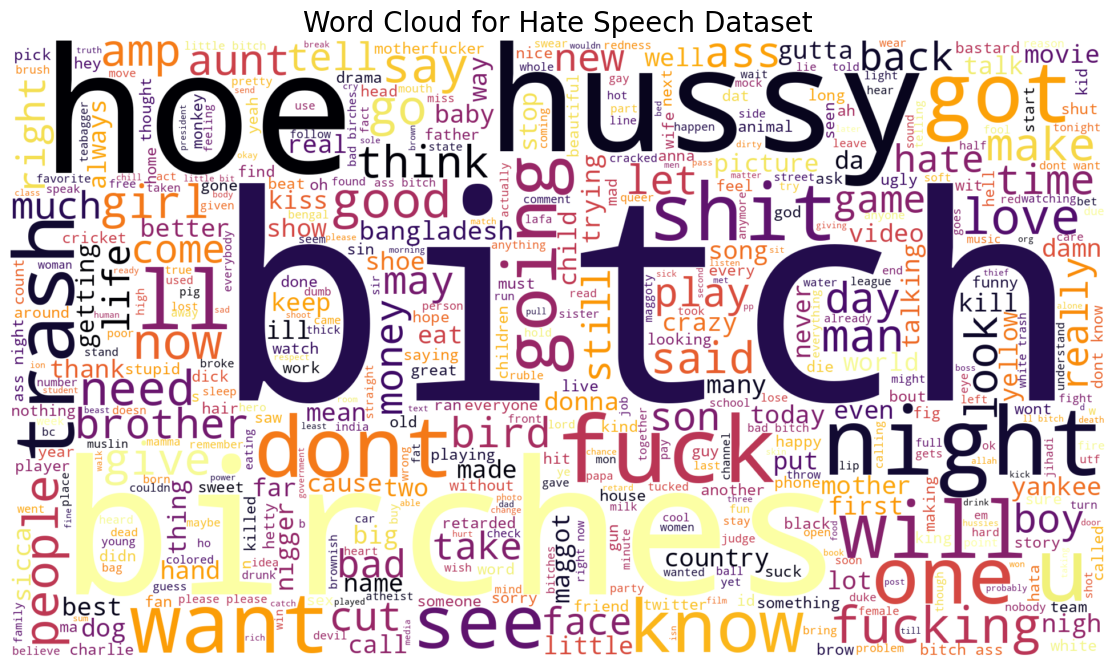

In [ ]:
# Check for the column containing text data
# MODIFY 'text' to the actual column name that contains the text
text_data = df['sentence']

# Combine all text into a single string
text = " ".join(str(text) for text in text_data)

# Generate the word cloud
wordcloud = WordCloud(
    width=1920,
    height=1080,
    background_color='white',
    colormap='inferno',
    max_words=500
).generate(text)

# Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title("Word Cloud for Hate Speech Dataset", fontsize=20)
plt.show()

In [5]:
# Install necessary libraries
!pip install transformers==4.17 matplotlib pandas scikit-learn torch optuna

# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments, TrainerCallback
import torch
import os
import matplotlib.pyplot as plt
import pandas as pd
import optuna

# Load the dataset (assuming df['sentence'] and df['labels'] exist)
# Replace `df` with your actual DataFrame
# Example:
# df = pd.read_csv('/path/to/your/dataset.csv')

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['sentence'], df['labels'], test_size=0.2, random_state=42
)

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Tokenize the training and testing data
train_encodings = tokenizer(train_texts.astype(str).tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.astype(str).tolist(), truncation=True, padding=True, max_length=128)

# Define a custom dataset class
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = pd.to_numeric(labels, errors='coerce').fillna(0).astype(int).tolist()  # Ensure numeric labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the datasets
train_dataset = HateSpeechDataset(train_encodings, train_labels)
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Disable WandB logging
os.environ["WANDB_DISABLED"] = "true"

# Define the compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define a custom callback to track metrics
class MetricsHistoryCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if 'eval_loss' in metrics:
            self.eval_losses.append(metrics['eval_loss'])
        if 'eval_accuracy' in metrics:
            self.eval_accuracies.append(metrics['eval_accuracy'])

# Optuna optimization function
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        max_grad_norm=1.0,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        lr_scheduler_type="linear",
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        disable_tqdm=False
    )

    metrics_callback = MetricsHistoryCallback()

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[metrics_callback]
    )

    trainer.train()

    # Return the best validation accuracy for Optuna
    return max(metrics_callback.eval_accuracies)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Print best parameters
print("Best parameters:", study.best_params)

# Train the final model with best parameters
best_params = study.best_params
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    max_grad_norm=1.0,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    disable_tqdm=False
)

metrics_callback = MetricsHistoryCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

trainer.train()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.17.0 which is incompatible.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

[I 2025-01-17 18:00:59,598] A new study created in memory with name: no-name-ea36f6f4-2ef5-49c2-968f-0597e73c888e
<ipython-input-5-895a31f38626>:82: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.277900,0.266373,0.899687,0.911536,0.921227,0.902048
2,0.239600,0.249855,0.906531,0.918319,0.919576,0.917065
3,0.152100,0.315757,0.905944,0.918044,0.916638,0.919454


[I 2025-01-17 18:16:00,002] Trial 0 finished with value: 0.906531091122409 and parameters: {'learning_rate': 6.226260378235164e-05, 'batch_size': 16}. Best is trial 0 with value: 0.906531091122409.
<ipython-input-5-895a31f38626>:82: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.286800,0.269276,0.894212,0.906740,0.916057,0.897611
2,0.199500,0.247520,0.905553,0.916738,0.926158,0.907509
3,0.116900,0.305534,0.904185,0.916496,0.915248,0.917747


[I 2025-01-17 18:28:35,622] Trial 1 finished with value: 0.9055533828705514 and parameters: {'learning_rate': 7.402235536709231e-05, 'batch_size': 32}. Best is trial 0 with value: 0.906531091122409.
<ipython-input-5-895a31f38626>:82: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecate

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.285800,0.267298,0.890301,0.901250,0.930571,0.873720
2,0.216700,0.246514,0.904967,0.915566,0.932413,0.899317
3,0.178100,0.266952,0.900860,0.913021,0.917903,0.908191


[I 2025-01-17 18:41:31,254] Trial 2 finished with value: 0.9049667579194368 and parameters: {'learning_rate': 1.521170460512789e-05, 'batch_size': 32}. Best is trial 0 with value: 0.906531091122409.
<ipython-input-5-895a31f38626>:82: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecate

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.388300,0.377040,0.835549,0.850436,0.887857,0.816041
2,0.377900,0.332196,0.862925,0.875995,0.909291,0.845051
3,0.315000,0.327547,0.862339,0.876751,0.900072,0.854608


[I 2025-01-17 18:56:11,963] Trial 3 finished with value: 0.8629253030895581 and parameters: {'learning_rate': 1.0466571529527468e-06, 'batch_size': 16}. Best is trial 0 with value: 0.906531091122409.
<ipython-input-5-895a31f38626>:82: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecat

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.371500,0.331645,0.866641,0.878863,0.916296,0.844369
2,0.155000,0.331608,0.877982,0.890025,0.920190,0.861775
3,0.285200,0.337167,0.880524,0.893573,0.912487,0.875427


[I 2025-01-17 19:14:09,257] Trial 4 finished with value: 0.8805240516229957 and parameters: {'learning_rate': 1.5587950664312396e-06, 'batch_size': 8}. Best is trial 0 with value: 0.906531091122409.


Best parameters: {'learning_rate': 6.226260378235164e-05, 'batch_size': 16}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.269800,0.254575,0.897341,0.909122,0.922374,0.896246
2,0.226700,0.262729,0.900665,0.914015,0.906649,0.921502
3,0.189000,0.378726,0.906140,0.916464,0.935014,0.898635
4,0.156900,0.410945,0.899101,0.912483,0.906945,0.918089
5,0.082400,0.521359,0.897732,0.910614,0.912016,0.909215


TrainOutput(global_step=6395, training_loss=0.1874182055665703, metrics={'train_runtime': 1535.0196, 'train_samples_per_second': 66.631, 'train_steps_per_second': 4.166, 'total_flos': 3387191383633920.0, 'train_loss': 0.1874182055665703, 'epoch': 5.0})

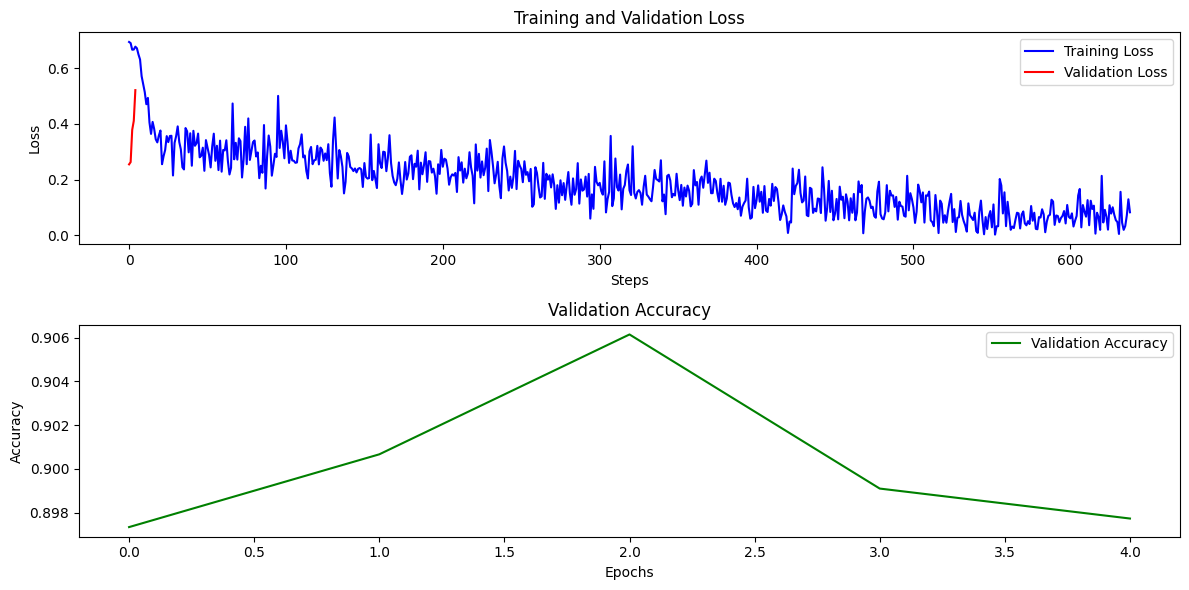

In [6]:
import matplotlib.pyplot as plt

# Plot training loss, validation loss, and validation accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(metrics_callback.train_losses, label='Training Loss', color='blue')
plt.plot(metrics_callback.eval_losses, label='Validation Loss', color='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 1, 2)
plt.plot(metrics_callback.eval_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

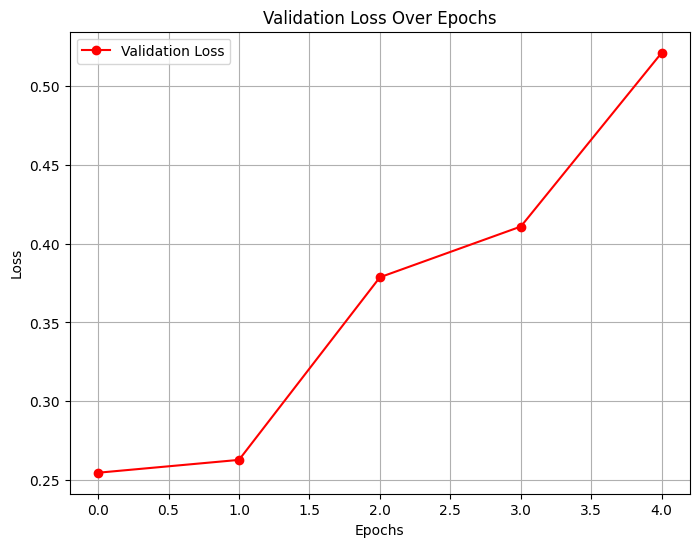

In [7]:
# Plot validation loss individually
plt.figure(figsize=(8, 6))
plt.plot(metrics_callback.eval_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

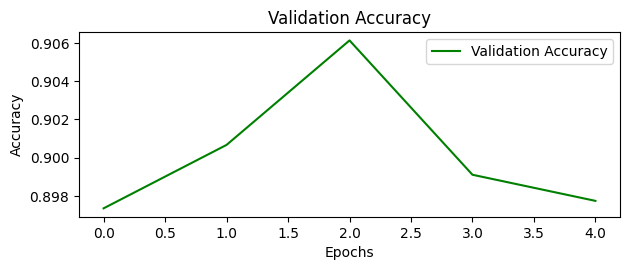

In [8]:
# Plot validation accuracy
plt.subplot(2, 1, 2)
plt.plot(metrics_callback.eval_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)  # Get raw predictions and labels
predicted_labels = np.argmax(predictions, axis=1)

***** Running Prediction *****
  Num examples = 5114
  Batch size = 16


# **Plot the training and validation loss curves**

In [10]:
predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(labels, predicted_labels)

# Print the accuracy
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9061


# **Confusion Matrix**
Source: https://youtu.be/8gLewErTU24?si=IYIN6qnx0ylYFSok

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
confusion_matrix(test_labels, predicted_labels)

array([[2001,  183],
       [ 297, 2633]])

In [13]:
#Getting dataframe labels

from sklearn.utils.multiclass import unique_labels
unique_labels(test_labels)

array([0, 1])

In [14]:
#Combining these labels with the confusion matrix

def plot(y_true, y_pred):
  labels = unique_labels(test_labels)
  column = [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=column, index=indices)

  return table

In [15]:
plot(test_labels, predicted_labels)

,Predicted 0,Predicted 1
Actual 0,2001,183
Actual 1,297,2633


In [16]:
def plot2(y_true, y_pred):
  labels = unique_labels(test_labels)
  column = [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=column, index=indices)

  return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

<Axes: >

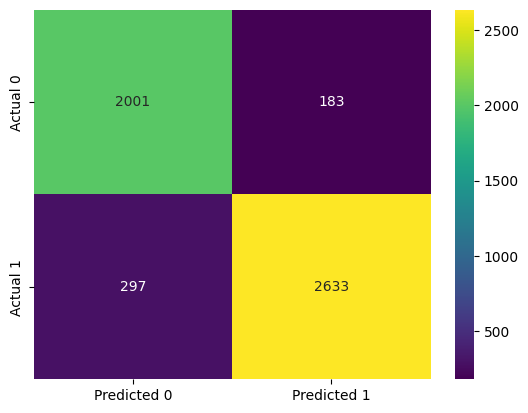

In [17]:
plot2(test_labels, predicted_labels)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2184
           1       0.94      0.90      0.92      2930

    accuracy                           0.91      5114
   macro avg       0.90      0.91      0.90      5114
weighted avg       0.91      0.91      0.91      5114



# **ROC and AUC**
Source: https://github.com/Suji04/Diabetes-Detection/blob/master/ROC%20AUC%20demo.ipynb

In [19]:
# Import necessary libraries for ROC and AUC
from sklearn.metrics import roc_curve, auc
import numpy as np
import torch

# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# Convert logits to probabilities
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()  # Take the probability of the positive class
true_labels = predictions.label_ids  # True labels from the dataset

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

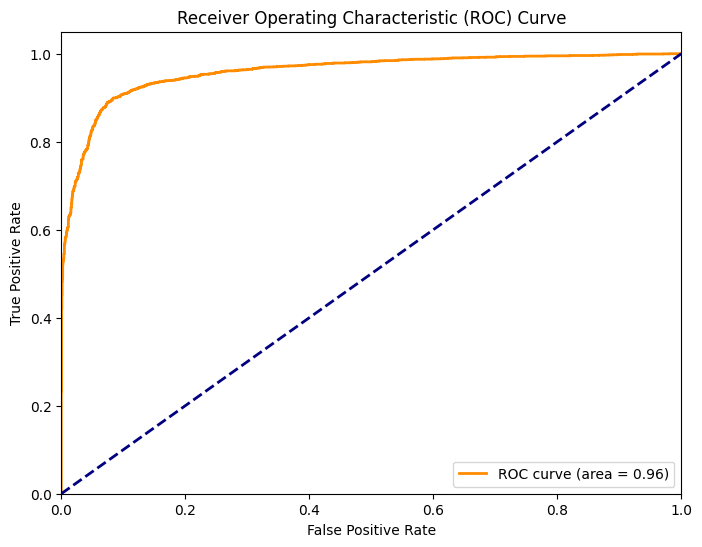

AUC: 0.96


In [20]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display AUC
print(f"AUC: {roc_auc:.2f}")

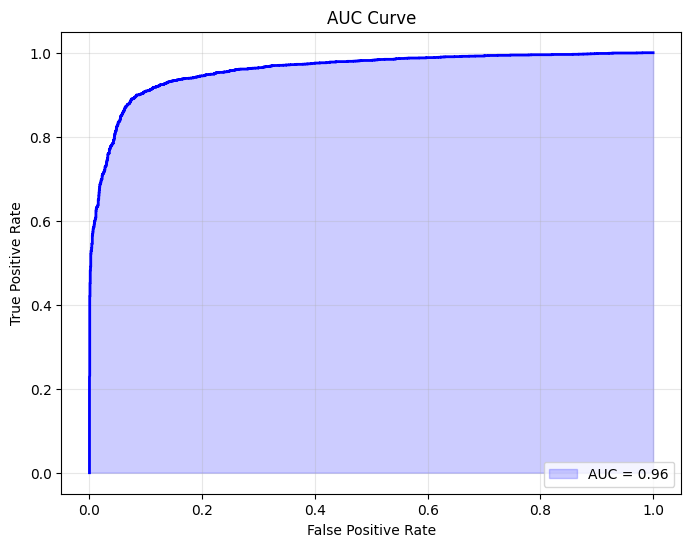

In [21]:
# Plot the AUC curve separately
plt.figure(figsize=(8, 6))
plt.fill_between(fpr, tpr, color='blue', alpha=0.2, label=f'AUC = {roc_auc:.2f}')
plt.plot(fpr, tpr, color='blue', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# **K Fold Cross Validation**

In [22]:
import torch
from torch.utils.data import DataLoader, Subset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the custom callback to track accuracy
class AccuracyHistoryCallback(TrainerCallback):  # Added the AccuracyHistoryCallback class definition
    def __init__(self):
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if 'eval_accuracy' in metrics:
            self.eval_accuracies.append(metrics['eval_accuracy'])
            print(f"Validation accuracy: {metrics['eval_accuracy']}")

#class HateSpeechDataset(torch.utils.data.Dataset):

# Define your dataset (modify this section)
# Ensure train_dataset is a Hugging Face Dataset or a compatible PyTorch Dataset
# Example (replace this with your actual data):
# dataset = load_dataset('your_dataset_here')
# train_dataset = dataset['train']
# labels = train_dataset['labels']  # Extract labels for splitting

# Replace the following with your actual dataset
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels): # Added encodings and labels as input
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

dataset = HateSpeechDataset(train_encodings, train_labels)
labels = train_labels

# Initialize K-Fold Cross-Validation
NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Initialize callback
accuracy_callback = AccuracyHistoryCallback()

# Cross-validation loop
fold_results = []
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset, labels)):
    print(f"Starting Fold {fold + 1}/{NUM_FOLDS}")

    # Split dataset into train and validation sets
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    # Evaluate the model
    eval_metrics = trainer.evaluate()
    print(f"Fold {fold + 1} - Evaluation Metrics: {eval_metrics}")

    fold_results.append(eval_metrics['eval_accuracy'])

# Print overall results
print(f"K-Fold Cross-Validation Results: {fold_results}")
print(f"Mean Accuracy: {sum(fold_results) / len(fold_results):.4f}")

Starting Fold 1/5


Fold 1 - Evaluation Metrics: {'eval_loss': 0.37872645258903503, 'eval_accuracy': 0.906140007821666, 'eval_f1': 0.9164636268708667, 'eval_precision': 0.9350142045454546, 'eval_recall': 0.8986348122866894, 'eval_runtime': 14.3534, 'eval_samples_per_second': 356.291, 'eval_steps_per_second': 22.294, 'epoch': 5.0}
Starting Fold 2/5
Fold 2 - Evaluation Metrics: {'eval_loss': 0.37872645258903503, 'eval_accuracy': 0.906140007821666, 'eval_f1': 0.9164636268708667, 'eval_precision': 0.9350142045454546, 'eval_recall': 0.8986348122866894, 'eval_runtime': 14.7574, 'eval_samples_per_second': 346.538, 'eval_steps_per_second': 21.684, 'epoch': 5.0}
Starting Fold 3/5
Fold 3 - Evaluation Metrics: {'eval_loss': 0.37872645258903503, 'eval_accuracy': 0.906140007821666, 'eval_f1': 0.9164636268708667, 'eval_precision': 0.9350142045454546, 'eval_recall': 0.8986348122866894, 'eval_runtime': 13.9119, 'eval_samples_per_second': 367.599, 'eval_steps_per_second': 23.002, 'epoch': 5.0}
Starting Fold 4/5
Fold 4 - E

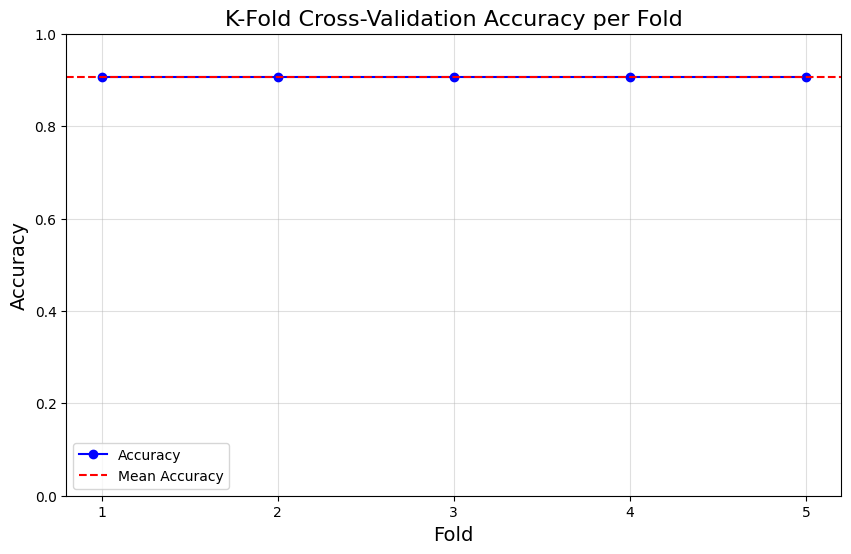

In [23]:
import matplotlib.pyplot as plt

# K-Fold Cross-Validation Results Visualization
folds = list(range(1, NUM_FOLDS + 1))  # Fold numbers

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(folds, fold_results, marker='o', linestyle='-', color='b', label='Accuracy')
plt.axhline(y=sum(fold_results) / len(fold_results), color='r', linestyle='--', label='Mean Accuracy')  # Mean accuracy line

# Add labels and title
plt.title('K-Fold Cross-Validation Accuracy per Fold', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(folds)  # Set x-axis ticks to fold numbers
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.legend()
plt.grid(alpha=0.4)

# Show the plot
plt.show()

# **XAI (Explainable Artificial Intelligence)**

**LIME (Local Interprtable Model-Agnostic Explanations) Application**

In [24]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=88cc7c386ccdb5677f497b8898162354b4b907dcf950c8033f7c5c62f8716e17
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [25]:
# Import required libraries
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch
import gc
import matplotlib.pyplot as plt

# Clear unused variables and GPU memory
if 'sample_texts' in locals():
    del sample_texts
if 'fig' in locals():
    del fig

gc.collect()
torch.cuda.empty_cache()

# Define a prediction function for LIME
def predict_fn(texts):
    # Tokenize input texts
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    # Move tensors to the same device as the model
    with torch.no_grad():
        outputs = model(**{key: val.to(model.device) for key, val in encodings.items()})
    # Move logits to CPU before converting to NumPy array
    return outputs.logits.cpu().numpy()

# Initialize the LIME text explainer
explainer = LimeTextExplainer(class_names=['Not Hate Speech', 'Hate Speech'])

# Display 10 sentences from the test set
print("First 10 sentences from the test set:")
test_sentences = test_texts.tolist()[:10]  # Convert test_texts to a list and slice the first 10 sentences
for idx, sentence in enumerate(test_sentences, start=1):
    print(f"{idx}: {sentence}")

# Generate and display explanations for each sentence
for idx, text_to_explain in enumerate(test_sentences, start=1):
    print(f"\nGenerating LIME explanation for sentence {idx}:")
    print(f"\"{text_to_explain}\"\n")

    # Generate LIME explanation
    exp = explainer.explain_instance(
        text_to_explain, predict_fn, num_features=5, num_samples=500
    )

    # Show the explanation in the notebook
    exp.show_in_notebook(text=True)

    # Optionally visualize the explanation as a plot
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Sentence {idx}')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

hey bitch


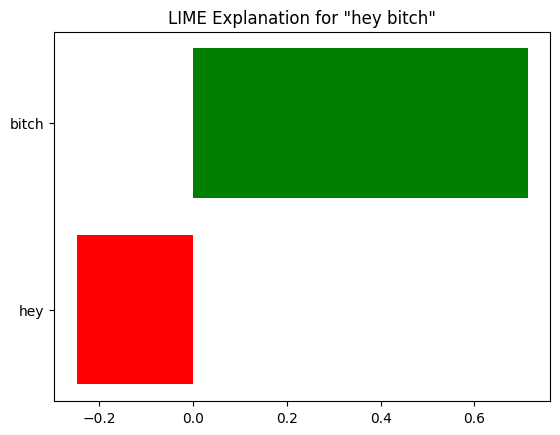

In [ ]:
'''from lime.lime_text import LimeTextExplainer

# Define the class names for your task
class_names = ['Not Hate Speech', 'Hate Speech']

# Function to predict probabilities using the DistilBERT model
def predictor(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
    inputs = inputs.to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    return probabilities.cpu().numpy()

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

# Choose a sample text to explain
sample_text = (input())

# Generate LIME explanation
exp = explainer.explain_instance(sample_text, predictor, num_features=6)

# Display explanation in notebook
exp.show_in_notebook(text=sample_text)

# Optionally visualize the explanation as a plot # Removed extra indent
fig = exp.as_pyplot_figure() # Removed extra indent
plt.title(f'LIME Explanation for "{sample_text}"') # Removed idx, which is out of scope, and replaced with the actual text
plt.show() # Removed extra indent